In [1]:
import torch
import numpy as np
import pandas as pd
import ast
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import random
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('data/cpu_data_custom_orangepi.csv')

# Convert string representation of lists back to actual lists
df['features'] = df['features'].apply(ast.literal_eval)
df.reset_index(drop=True, inplace=True)

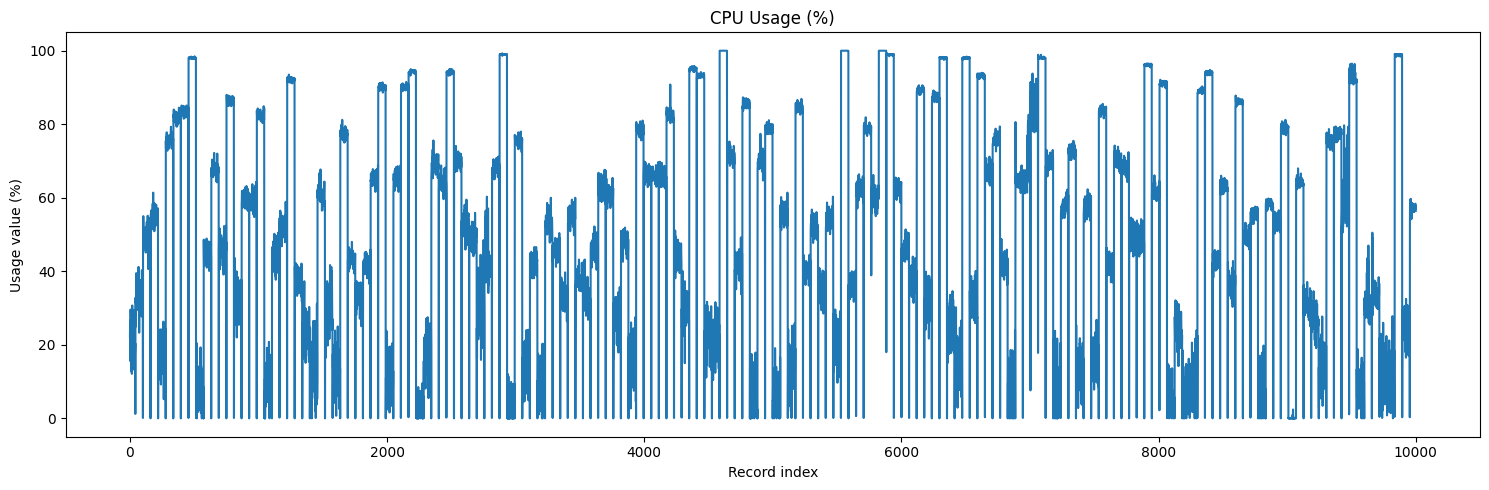

In [30]:
plt.figure(figsize=(15,5))
plt.plot(df.index[:10000], df['target'][:10000])
plt.xlabel('Record index')
plt.ylabel('Usage value (%)')
plt.title('CPU Usage (%)')
plt.tight_layout() 
plt.show()

In [29]:
task1_data = df[0:2000]
task2_data = df[3000:4000]
test_data = df[6000:6500]

In [5]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, input):
        lstm_out, _ = self.lstm(input.view(len(input), 1, -1))
        output = self.fc(lstm_out.view(len(input), -1))
        return output[-1]

In [6]:
class CustomDataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        sample = self.dataframe.iloc[idx]
        x = torch.tensor(sample['features'], dtype=torch.float32)
        y = torch.tensor(sample['target'], dtype=torch.float32)
        return x, y

In [7]:
def train_model(model, dataloader, criterion, optimizer, epochs=10):
    
    for epoch in range(epochs):
        running_loss = 0.0
        for i, data in enumerate(dataloader, 0):
            inputs, labels = data
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f'Epoch {epoch+1}, Loss: {running_loss/len(dataloader)}')

In [8]:
def finetune_model(model, dataloader, criterion, optimizer, epochs=10):
    for epoch in range(epochs):
        running_loss = 0.0
        model.train()  # Set the model to training mode
        
        for i, data in enumerate(dataloader, 0):
            inputs, labels = data
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        print(f'Last Epoch {epoch+1}, Loss: {running_loss/len(dataloader)}')

In [9]:
def test_model(test_dataloader):
    test_running_loss = 0.0
    test_total_samples = 0
    test_absolute_errors = 0.0
    
    # Switch model to evaluation mode
    model.eval()
    
    with torch.no_grad():  # No need to compute gradients during testing
        for data in test_dataloader:
            inputs, labels = data
            
            # Forward pass
            outputs = model(inputs)
            
            # Calculate loss (MSE or MAE)
            test_loss = criterion(outputs, labels)
            test_running_loss += test_loss.item()
            
            # Calculate absolute error (MAE)
            test_absolute_error = torch.abs(outputs - labels)
            test_absolute_errors += test_absolute_error.sum().item()
            
            # Update total samples
            test_total_samples += labels.size(0)
    
    # Calculate Mean Absolute Error (MAE) on test dataset
    test_mean_absolute_error = test_absolute_errors / test_total_samples
    
    # Print loss and MAE on test dataset
    print(f'Test Loss: {test_running_loss/len(test_dataloader)}, Test MAE: {test_mean_absolute_error}')

In [10]:
input_size = 8  # Input size is the length of the input list
hidden_size = 16
output_size = 1
learning_rate = 0.001
epochs = 10

In [11]:
model = LSTMModel(input_size, hidden_size, output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [12]:
print("======== Task 1 Training ========")
task1_dataset = CustomDataset(task1_data)
task1_dataloader = DataLoader(task1_dataset, batch_size=1, shuffle=True)
# Train the model for task 1
train_model(model, task1_dataloader, criterion, optimizer, epochs)

======== Task 1 Training ========
Epoch 1, Loss: 2475.9844742278656
Epoch 2, Loss: 1380.4097126734741
Epoch 3, Loss: 806.8590325503845
Epoch 4, Loss: 479.74153508049795
Epoch 5, Loss: 287.05517479734976
Epoch 6, Loss: 180.0849335394607
Epoch 7, Loss: 115.01414556795457
Epoch 8, Loss: 77.58162846999548
Epoch 9, Loss: 62.83466479311998
Epoch 10, Loss: 56.573929736408026


In [13]:
task2_dataset = CustomDataset(test_data)
test_dataloader = DataLoader(task2_dataset, batch_size=1, shuffle=True)

In [14]:
test_model(test_dataloader)

Test Loss: 84.05995591338025, Test MAE: 7.364653900146484


In [15]:
print("\n======== Task 2 Training ========")
task2_dataset = CustomDataset(task2_data)
task2_dataloader = DataLoader(task2_dataset, batch_size=1, shuffle=False)
# Finetune the model using task 2 data
finetune_model(model, task2_dataloader, criterion, optimizer, epochs)


======== Task 2 Training ========
Last Epoch 1, Loss: 53.04731024265693
Last Epoch 2, Loss: 47.80834468849191
Last Epoch 3, Loss: 49.71759169784531
Last Epoch 4, Loss: 46.47455435656274
Last Epoch 5, Loss: 45.18656372097077
Last Epoch 6, Loss: 53.38324346408808
Last Epoch 7, Loss: 44.73080078240768
Last Epoch 8, Loss: 48.70980360600719
Last Epoch 9, Loss: 45.92188667253011
Last Epoch 10, Loss: 44.70091022959555


In [16]:
test_model(test_dataloader)

Test Loss: 172.69566552338284, Test MAE: 11.401690282583237


# Handeling Catastophic Forgetting in Continual Learning

In [17]:
# Initialize the rehearsal buffer
rehearsal_buffer = []
def train_model_with_rehearsal(model, dataloader, criterion, optimizer, epochs=10, finetune='No'):
    global rehearsal_buffer
    if finetune=='Yes':
        model.train()  # Set the model to training mode
        
    for epoch in range(epochs):
        running_loss = 0.0
        for i, data in enumerate(dataloader, 0):
            inputs, labels = data
            
            # Include samples from the rehearsal buffer
            if len(rehearsal_buffer) > 0:
                rehearsal_samples = random.sample(rehearsal_buffer, min(len(rehearsal_buffer), len(inputs)))
                for rehearsal_input, rehearsal_label in rehearsal_samples:
                    inputs = torch.cat((inputs, rehearsal_input.unsqueeze(0)), dim=0)
                    labels = torch.cat((labels, rehearsal_label.unsqueeze(0)), dim=0)
                    
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f'Epoch {epoch+1}, Loss: {running_loss/len(dataloader)}')

In [18]:
model = LSTMModel(input_size, hidden_size, output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [19]:
print("======== Task 1 Training ========")
task1_dataset = CustomDataset(task1_data)
task1_dataloader = DataLoader(task1_dataset, batch_size=1)
# Train the model for task 1
train_model_with_rehearsal(model, task1_dataloader, criterion, optimizer, epochs)

======== Task 1 Training ========
Epoch 1, Loss: 2613.440490406123
Epoch 2, Loss: 1409.6817212864853
Epoch 3, Loss: 845.1741129123735
Epoch 4, Loss: 544.8240520589479
Epoch 5, Loss: 459.56960335622284
Epoch 6, Loss: 377.9922906519291
Epoch 7, Loss: 198.46807461484454
Epoch 8, Loss: 139.15551462050655
Epoch 9, Loss: 125.99296233406487
Epoch 10, Loss: 92.5293727909155


In [20]:
print("\n======== Task 2 Training ========")
task2_dataset = CustomDataset(task2_data)
task2_dataloader = DataLoader(task2_dataset, batch_size=1)
# Finetune the model using task 2 data
train_model_with_rehearsal(model, task2_dataloader, criterion, optimizer, epochs, finetune='Yes')


======== Task 2 Training ========
Epoch 1, Loss: 59.73880992848944
Epoch 2, Loss: 65.83137032386288
Epoch 3, Loss: 46.06541425457079
Epoch 4, Loss: 58.254156359670375
Epoch 5, Loss: 49.35520865761244
Epoch 6, Loss: 52.89190819187905
Epoch 7, Loss: 54.30681020805365
Epoch 8, Loss: 49.85975811970352
Epoch 9, Loss: 52.00296833767557
Epoch 10, Loss: 49.74491580929409


In [21]:
test_model(test_dataloader)

Test Loss: 153.11871374410728, Test MAE: 10.593476903438567


# Updateting with rehearsal_ratio

In [22]:
# Initialize the rehearsal buffer
rehearsal_buffer = []

def train_model_with_rehearsal_ratio(model, dataloader, criterion, optimizer, epochs=10, rehearsal_ratio=0.5, finetune='No'):
    global rehearsal_buffer

    if finetune=='Yes':
        model.train()  # Set the model to training mode
        
    for epoch in range(epochs):
        running_loss = 0.0
        for i, data in enumerate(dataloader, 0):
            inputs, labels = data
            
            # Include samples from the rehearsal buffer
            if len(rehearsal_buffer) > 0 and random.random() < rehearsal_ratio:
                rehearsal_samples = random.sample(rehearsal_buffer, min(len(rehearsal_buffer), len(inputs)))
                for rehearsal_input, rehearsal_label in rehearsal_samples:
                    inputs = torch.cat((inputs, rehearsal_input.unsqueeze(0)), dim=0)
                    labels = torch.cat((labels, rehearsal_label.unsqueeze(0)), dim=0)
                    
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f'Epoch {epoch+1}, Loss: {running_loss/len(dataloader)}')


In [23]:
model = LSTMModel(input_size, hidden_size, output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [24]:
# Training for task 1
print("======== Task 1 Training ========")
task1_dataset = CustomDataset(task1_data)
task1_dataloader = DataLoader(task1_dataset, batch_size=1, shuffle=True)
train_model_with_rehearsal_ratio(model, task1_dataloader, criterion, optimizer, epochs)

======== Task 1 Training ========
Epoch 1, Loss: 2655.1735697849563
Epoch 2, Loss: 1581.2132563655664
Epoch 3, Loss: 934.1332259596883
Epoch 4, Loss: 570.8659170315178
Epoch 5, Loss: 352.1047274077993
Epoch 6, Loss: 221.79164992306173
Epoch 7, Loss: 145.43265273551486
Epoch 8, Loss: 100.00901653669206
Epoch 9, Loss: 70.34534178089059
Epoch 10, Loss: 60.71457758775464


In [25]:
print("\n======== Task 2 Training ========")
task2_dataset = CustomDataset(task2_data)
task2_dataloader = DataLoader(task2_dataset, batch_size=1, shuffle=True)
# Finetune the model using task 2 data
train_model_with_rehearsal_ratio(model, task2_dataloader, criterion, optimizer, epochs, finetune='Yes')


======== Task 2 Training ========
Epoch 1, Loss: 52.61133524365795
Epoch 2, Loss: 46.4532950912199
Epoch 3, Loss: 44.96544021793713
Epoch 4, Loss: 44.76716325277995
Epoch 5, Loss: 41.71673779921119
Epoch 6, Loss: 40.86847727490353
Epoch 7, Loss: 39.529238776057284
Epoch 8, Loss: 40.23456376635256
Epoch 9, Loss: 38.09768544920575
Epoch 10, Loss: 36.94566426911544


In [26]:
test_model(test_dataloader)

Test Loss: 153.3867077753055, Test MAE: 10.23769776391983
